In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import lightgbm as lgb
# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tqdm import tqdm
import math

In [2]:
seed = 42

## Import Data

In [3]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submit.csv", names=['id', 'pred'])

In [4]:
train_df = train_df.drop(['id'], axis=1)
test_df = test_df.drop(['id'], axis=1)

## Explore Data

In [5]:
#train_df.describe()

## Feature Engineering

In [6]:
# 関節ビル(B_Bil)　＋　直接ビル(D_Bil)　＝　総ビル(T_Bil)
train_df["B_Bil"] = train_df["T_Bil"].values - train_df["D_Bil"].values
test_df["B_Bil"] = test_df["T_Bil"].values - test_df["D_Bil"].values

In [7]:
# if abs(AST / ALT) > 0 then bad
train_df["AST_ALT_ratio"] = abs(train_df["AST_GOT"].values/train_df["ALT_GPT"].values)
test_df["AST_ALT_ratio"] = abs(test_df["AST_GOT"].values/test_df["ALT_GPT"].values)

In [8]:
df_gender = pd.get_dummies(train_df['Gender'])
train_df = pd.concat([train_df, df_gender], axis=1)
train_df = train_df.drop("Gender", axis=1)

df_gender = pd.get_dummies(test_df['Gender'])
test_df = pd.concat([test_df, df_gender], axis=1)
test_df = test_df.drop("Gender", axis=1)

In [9]:
columns = list(train_df.columns)

In [10]:
columns.remove("disease")
columns.remove("Female")
columns.remove("Male")

In [11]:
for col in columns:
    col_name = str(col) + "_log"
    train_df[col_name] = np.log(train_df[col])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [12]:
columns2 = list(test_df.columns)

columns2.remove("Female")
columns2.remove("Male")

for col in columns2:
    col_name = str(col) + "_log"
    test_df[col_name] = np.log(test_df[col])

In [13]:
train_df['B_Bil_log'] = train_df['B_Bil_log'].fillna(0)

## Clean Data (Normalize)

In [14]:
s = MinMaxScaler()
train_df2 = s.fit_transform(train_df)
test_df2 = s.fit_transform(test_df)

In [15]:
train_df2 = pd.DataFrame(train_df2, columns = train_df.columns)
test_df2 = pd.DataFrame(test_df2, columns = test_df.columns)

## Feature Selection

In [ ]:
#Using Pearson Correlation
# plt.figure(figsize=(12,10))
# cor = train_df2.corr()
# sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
# plt.show()

In [124]:
df = train_df2
test_df = test_df2

## Create X and y

In [125]:
y = df[["disease"]]

In [126]:
y = y.astype({"disease": int}).values

In [127]:
X = df.drop(["disease"], axis = 1)

In [128]:
y = y.ravel()

#### Best features = Age Gender T_Bil ALP ALT_GPT TP Alb AG_ratio B_Bil AST_ALT_ratio

## Train Test Split

In [129]:
X.columns

Index(['Age', 'T_Bil', 'D_Bil', 'ALP', 'ALT_GPT', 'AST_GOT', 'TP', 'Alb',
       'AG_ratio', 'B_Bil', 'AST_ALT_ratio', 'Female', 'Male', 'Age_log',
       'T_Bil_log', 'D_Bil_log', 'ALP_log', 'ALT_GPT_log', 'AST_GOT_log',
       'TP_log', 'Alb_log', 'AG_ratio_log', 'B_Bil_log', 'AST_ALT_ratio_log'],
      dtype='object')

In [130]:
# X_best = X[["Age", "Gender", "T_Bil", "ALP" ,"ALT_GPT" ,"TP", "Alb", "AG_ratio" ,"B_Bil" ,"AST_ALT_ratio"]]

In [131]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

## A. Training the Model (Logistic Regression)

In [26]:
from sklearn.pipeline import Pipeline
logReg_clf = LogisticRegression()
logReg_model = Pipeline(steps = [("classifier", logReg_clf)])

logReg_model.fit(X_train, y_train)

score = logReg_model.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.7622857142857142


## B. Training Model (Naives Bayes)

In [27]:
# Fitting a simple Naive Bayes on Counts
naiveBayes_model = MultinomialNB()

naiveBayes_model.fit(X_train, y_train)

score = naiveBayes_model.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.7348571428571429


## D. Training Model (Random Forest)

In [28]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200,
                                random_state = seed)
rf_model = Pipeline(steps = [("classifier", rf_clf)])

rf_model.fit(X_train, y_train)

score = rf_model.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.8537142857142858


## E. Traning Model (Linear Support Vector Classification)

In [29]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC(max_iter = 1000,
                    random_state = seed)

svc_clf.fit(X_train, y_train)

score = svc_clf.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.7702857142857142


## F. Training Model (Extra Trees Classifier)

In [30]:
from sklearn.ensemble import ExtraTreesClassifier

et_clf = ExtraTreesClassifier(n_estimators = 500,
                              random_state = seed)

et_clf.fit(X_train, y_train)

score = et_clf.score(X_val, y_val)

print("Accuracy:", score)

Accuracy: 0.8537142857142858


## E. LightGBM

In [152]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.546977  0.208255  0.110851  0.332943


In [155]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.549591  0.210937  0.110211  0.331981


In [158]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.549591  0.210937  0.110211  0.331981


In [161]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.551724  0.208123  0.109689  0.331194


In [163]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.551724  0.208123  0.109689  0.331194


In [183]:
scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.549591  0.210937  0.110211  0.331981


In [149]:
# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
# trainのデータセットの3割をモデル学習時のバリデーションデータとして利用する
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)

# LightGBMを利用するのに必要なフォーマットに変換
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [186]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'l2','l1'},
    'num_leaves': 50,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'vervose': 0
}

In [187]:
# LightGBM学習
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=1000,
                valid_sets=lgb_eval,
                early_stopping_rounds=50
               )

# LightGBM推論
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)

[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Warning] Unknown parameter: vervose
[LightGBM] [Info] Number of positive: 915, number of negative: 1325
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5216
[LightGBM] [Info] Number of data points in the train set: 2240, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.408482 -> initscore=-0.370244
[LightGBM] [Info] Start training from score -0.370244
[1]	valid_0's l2: 0.232402	valid_0's l1: 0.473611
Training until validation scores don't improve for 50 rounds
[2]	valid_0's l2: 0.222573	valid_0's l1: 0.462941
[3]	valid_0's l2: 0.214291	valid_0's l1: 0.453167
[4]	valid_0's l2: 0.206359	valid_0's l1: 0.443446
[5]	va

In [112]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame({'R2': r2_score(true, pred),
                          'MAE': mean_absolute_error(true, pred),
                          'MSE': mean_squared_error(true, pred),
                          'RMSE': np.sqrt(mean_squared_error(true, pred))},
                           index = ['scores'])
    return scores

In [136]:
# ALL features, objective = regression: 
#               R2       MAE       MSE     RMSE
# scores  0.530204  0.229578  0.114955  0.33905

In [135]:
# ALL features, objective = binary: 
#               R2       MAE       MSE      RMSE
# scores  0.546977  0.208255  0.110851  0.332943

scores = calculate_scores(y_test, y_pred)
print(scores)

              R2       MAE       MSE      RMSE
scores  0.546977  0.208255  0.110851  0.332943


In [137]:
# Top 10 features, objective = regression: 
#               R2       MAE       MSE      RMSE
# scores  0.519066  0.231667  0.117681  0.343046

In [138]:
# Top 10 features, objective = binary: 
#               R2       MAE       MSE      RMSE
# scores  0.534537  0.213649  0.113895  0.337483

In [169]:
y_pred_gbm_val = gbm.predict(X_val)

LightGBMError: The number of features in data (23) is not the same as it was in training data (24).
You can set ``predict_disable_shape_check=true`` to discard this error, but please be aware what you are doing.

In [170]:
y_pred_gbm_val_int = np.round(y_pred_gbm_val).astype(int)

In [141]:
a,b,c,d = confusion_matrix(y_val, y_pred_gbm_val_int).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

466 51
70 288
correct: 754 incorrect: 121


## Feature Selection

In [66]:
from sklearn.feature_selection import RFE

In [75]:
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, 1)
fit = rfe.fit(X_train, y_train)
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass n_features_to_select=1 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Num Features: 1
Selected Features: [False False False False False False False False False False False False
 False False  True False False False False False False False False False]
Feature Ranking: [10 24 22 21  9 15 19  7 16 23 17 18 13 11  1  3  4  2  5  8 12 20  6 14]


In [79]:
ranking = list(fit.ranking_)
col = X_train.columns

In [90]:
df_importance = pd.DataFrame({'feature': col,'importance': ranking,})
df_importance = df_importance.sort_values(by = "importance")
df_importance

,feature,importance
14,T_Bil_log,1
17,ALT_GPT_log,2
15,D_Bil_log,3
16,ALP_log,4
18,AST_GOT_log,5
22,B_Bil_log,6
7,Alb,7
19,TP_log,8
4,ALT_GPT,9
0,Age,10


In [144]:
top = df_importance["feature"].to_list()[:-1]
top

['T_Bil_log',
 'ALT_GPT_log',
 'D_Bil_log',
 'ALP_log',
 'AST_GOT_log',
 'B_Bil_log',
 'Alb',
 'TP_log',
 'ALT_GPT',
 'Age',
 'Age_log',
 'Alb_log',
 'Male',
 'AST_ALT_ratio_log',
 'AST_GOT',
 'AG_ratio',
 'AST_ALT_ratio',
 'Female',
 'TP',
 'AG_ratio_log',
 'ALP',
 'D_Bil',
 'B_Bil']

In [145]:
X_imp = X[top]

In [146]:
X_imp

,T_Bil_log,ALT_GPT_log,D_Bil_log,ALP_log,AST_GOT_log,B_Bil_log,Alb,TP_log,ALT_GPT,Age,...,AST_ALT_ratio_log,AST_GOT,AG_ratio,AST_ALT_ratio,Female,TP,AG_ratio_log,ALP,D_Bil,B_Bil
0,0.089946,0.237739,0.223862,0.085380,0.316059,0.426557,0.603580,0.679707,0.011540,0.541667,...,0.565627,0.047381,0.187176,0.080215,0.0,0.578569,0.390896,0.019046,0.007005,0.395024
1,0.135594,0.128030,0.244362,0.114341,0.023488,0.456205,0.573186,0.717510,0.004393,0.861111,...,0.465377,0.001837,0.257358,0.043760,1.0,0.622254,0.483838,0.026558,0.008247,0.398277
2,0.202945,0.113081,0.371615,0.058837,0.012537,0.472039,0.573095,0.804082,0.003709,0.361111,...,0.471926,0.000959,0.305783,0.045557,0.0,0.728047,0.539257,0.012654,0.020544,0.400286
3,0.121448,0.140774,0.185741,0.118829,0.091682,0.456470,0.552490,0.732406,0.005021,0.861111,...,0.500932,0.008262,0.257125,0.054376,1.0,0.639878,0.483555,0.027774,0.005066,0.398309
4,0.328243,0.216428,0.451248,0.132027,0.408537,0.548603,0.240197,0.695803,0.009799,0.777778,...,0.650512,0.076940,0.259223,0.132447,0.0,0.596989,0.486088,0.031439,0.034659,0.413492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.150118,0.198362,0.250888,0.100623,0.120821,0.465609,0.815802,0.941273,0.008474,0.625000,...,0.466581,0.011589,0.286878,0.044085,1.0,0.913421,0.518339,0.022927,0.008675,0.399445
3496,0.580763,0.247009,0.662246,0.522152,0.322759,0.677669,0.224272,0.721254,0.012362,0.583333,...,0.561502,0.049175,0.048812,0.078267,0.0,0.626662,0.134320,0.225528,0.129379,0.457451
3497,0.073858,0.216871,0.229708,0.080811,0.185622,0.412876,0.099244,0.506385,0.009833,0.861111,...,0.494287,0.020537,0.017626,0.052225,0.0,0.396156,0.052715,0.017913,0.007344,0.393720
3498,0.336230,0.163243,0.291304,0.302112,0.366636,0.591029,0.053591,0.194500,0.006241,0.777778,...,0.671759,0.062188,0.011676,0.149998,0.0,0.131381,0.035529,0.092271,0.011737,0.424150


In [147]:
X_train, X_val, y_train, y_val = train_test_split(X_imp, y, test_size=0.25, random_state=seed)

## Confusion Matrix

In [42]:
# Logistic Regression
y_pred_lg_val = logReg_model.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_lg_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

474 43
165 193
correct: 667 incorrect: 208


In [43]:
# Naives Bayes
y_pred_naive_val = naiveBayes_model.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_naive_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

494 23
209 149
correct: 643 incorrect: 232


In [44]:
# Random Forest
y_pred_rf_val = rf_model.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_rf_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

452 65
63 295
correct: 747 incorrect: 128


In [45]:
# Support Vector Classification
y_pred_svc_val = svc_clf.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_svc_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

476 41
160 198
correct: 674 incorrect: 201


In [46]:
# Extra Trees Classifier
y_pred_et_val = et_clf.predict(X_val)
a,b,c,d = confusion_matrix(y_val, y_pred_et_val).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

458 59
69 289
correct: 747 incorrect: 128


## X. Training the Model (Sequential Model)

In [55]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=seed)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout

input_dim = X_train.shape[1]  # Number of features

seq_model = Sequential()
seq_model.add(Dense(10, input_dim=input_dim, activation='relu'))
seq_model.add(Dense(20, activation='relu'))
seq_model.add(Dropout(0.1))
seq_model.add(Dense(40, activation='relu'))
seq_model.add(Dense(1, activation='sigmoid'))

In [56]:
seq_model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
seq_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                250       
_________________________________________________________________
dense_5 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 41        
Total params: 1,351
Trainable params: 1,351
Non-trainable params: 0
_________________________________________________________________


In [57]:
history2 = seq_model.fit(X_train,
                        y_train,
                        epochs=1000,
                        validation_data=(X_val, y_val),
                        batch_size=512)

Epoch 1/1000
6/6 [==============================] - 1s 31ms/step - loss: 0.6852 - accuracy: 0.5844 - val_loss: 0.6746 - val_accuracy: 0.5909
Epoch 2/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.6757 - accuracy: 0.5844 - val_loss: 0.6641 - val_accuracy: 0.5909
Epoch 3/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.6666 - accuracy: 0.5844 - val_loss: 0.6536 - val_accuracy: 0.5909
Epoch 4/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.6587 - accuracy: 0.5878 - val_loss: 0.6441 - val_accuracy: 0.5909
Epoch 5/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.6502 - accuracy: 0.5954 - val_loss: 0.6346 - val_accuracy: 0.6263
Epoch 6/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.6395 - accuracy: 0.6286 - val_loss: 0.6230 - val_accuracy: 0.6537
Epoch 7/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.6313 - accuracy: 0.6491 - val_loss: 0.6112 - val_accuracy: 0.6926
Epoch 8/1000
6/6 [=

6/6 [==============================] - 0s 5ms/step - loss: 0.4731 - accuracy: 0.7676 - val_loss: 0.4461 - val_accuracy: 0.7840
Epoch 60/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4782 - accuracy: 0.7600 - val_loss: 0.4444 - val_accuracy: 0.7886
Epoch 61/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4742 - accuracy: 0.7756 - val_loss: 0.4485 - val_accuracy: 0.7966
Epoch 62/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4718 - accuracy: 0.7703 - val_loss: 0.4452 - val_accuracy: 0.7829
Epoch 63/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4736 - accuracy: 0.7650 - val_loss: 0.4429 - val_accuracy: 0.7920
Epoch 64/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4700 - accuracy: 0.7779 - val_loss: 0.4423 - val_accuracy: 0.7897
Epoch 65/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4653 - accuracy: 0.7741 - val_loss: 0.4428 - val_accuracy: 0.7829
Epoch 66/1000
6/6 [========

6/6 [==============================] - 0s 5ms/step - loss: 0.4388 - accuracy: 0.7920 - val_loss: 0.4219 - val_accuracy: 0.7931
Epoch 118/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4378 - accuracy: 0.7874 - val_loss: 0.4217 - val_accuracy: 0.7943
Epoch 119/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4371 - accuracy: 0.7973 - val_loss: 0.4207 - val_accuracy: 0.8000
Epoch 120/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4385 - accuracy: 0.7909 - val_loss: 0.4225 - val_accuracy: 0.7954
Epoch 121/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4366 - accuracy: 0.7878 - val_loss: 0.4210 - val_accuracy: 0.7989
Epoch 122/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4364 - accuracy: 0.7981 - val_loss: 0.4208 - val_accuracy: 0.8034
Epoch 123/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4356 - accuracy: 0.7912 - val_loss: 0.4221 - val_accuracy: 0.7909
Epoch 124/1000
6/6 [=

Epoch 175/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4183 - accuracy: 0.8030 - val_loss: 0.4131 - val_accuracy: 0.8057
Epoch 176/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4253 - accuracy: 0.7985 - val_loss: 0.4128 - val_accuracy: 0.8091
Epoch 177/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4200 - accuracy: 0.7985 - val_loss: 0.4127 - val_accuracy: 0.8080
Epoch 178/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4246 - accuracy: 0.8011 - val_loss: 0.4143 - val_accuracy: 0.8080
Epoch 179/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4197 - accuracy: 0.8008 - val_loss: 0.4147 - val_accuracy: 0.8034
Epoch 180/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4206 - accuracy: 0.8008 - val_loss: 0.4123 - val_accuracy: 0.8160
Epoch 181/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4215 - accuracy: 0.8019 - val_loss: 0.4141 - val_accuracy: 0.8057
Epoch 

Epoch 233/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4134 - accuracy: 0.8046 - val_loss: 0.4129 - val_accuracy: 0.8114
Epoch 234/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4136 - accuracy: 0.8069 - val_loss: 0.4121 - val_accuracy: 0.8149
Epoch 235/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4109 - accuracy: 0.8084 - val_loss: 0.4119 - val_accuracy: 0.8171
Epoch 236/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4140 - accuracy: 0.8080 - val_loss: 0.4092 - val_accuracy: 0.8183
Epoch 237/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4115 - accuracy: 0.8053 - val_loss: 0.4096 - val_accuracy: 0.8194
Epoch 238/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4158 - accuracy: 0.8061 - val_loss: 0.4085 - val_accuracy: 0.8183
Epoch 239/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4145 - accuracy: 0.8042 - val_loss: 0.4125 - val_accuracy: 0.8149
Epoch 

Epoch 291/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4037 - accuracy: 0.8099 - val_loss: 0.4093 - val_accuracy: 0.8183
Epoch 292/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4061 - accuracy: 0.8088 - val_loss: 0.4115 - val_accuracy: 0.8137
Epoch 293/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4028 - accuracy: 0.8133 - val_loss: 0.4086 - val_accuracy: 0.8171
Epoch 294/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4025 - accuracy: 0.8061 - val_loss: 0.4096 - val_accuracy: 0.8251
Epoch 295/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4002 - accuracy: 0.8110 - val_loss: 0.4097 - val_accuracy: 0.8171
Epoch 296/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4015 - accuracy: 0.8088 - val_loss: 0.4105 - val_accuracy: 0.8091
Epoch 297/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4022 - accuracy: 0.8076 - val_loss: 0.4096 - val_accuracy: 0.8206
Epoch 

Epoch 349/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.4005 - accuracy: 0.8080 - val_loss: 0.4071 - val_accuracy: 0.8206
Epoch 350/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3968 - accuracy: 0.8088 - val_loss: 0.4049 - val_accuracy: 0.8206
Epoch 351/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3989 - accuracy: 0.8110 - val_loss: 0.4049 - val_accuracy: 0.8251
Epoch 352/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3952 - accuracy: 0.8095 - val_loss: 0.4064 - val_accuracy: 0.8251
Epoch 353/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3957 - accuracy: 0.8072 - val_loss: 0.4057 - val_accuracy: 0.8217
Epoch 354/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3937 - accuracy: 0.8141 - val_loss: 0.4051 - val_accuracy: 0.8194
Epoch 355/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3968 - accuracy: 0.8141 - val_loss: 0.4042 - val_accuracy: 0.8183
Epoch 

Epoch 407/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3955 - accuracy: 0.8141 - val_loss: 0.4013 - val_accuracy: 0.8263
Epoch 408/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3867 - accuracy: 0.8198 - val_loss: 0.4011 - val_accuracy: 0.8263
Epoch 409/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3922 - accuracy: 0.8137 - val_loss: 0.4040 - val_accuracy: 0.8194
Epoch 410/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3897 - accuracy: 0.8187 - val_loss: 0.4008 - val_accuracy: 0.8183
Epoch 411/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3947 - accuracy: 0.8198 - val_loss: 0.4009 - val_accuracy: 0.8240
Epoch 412/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3892 - accuracy: 0.8194 - val_loss: 0.4004 - val_accuracy: 0.8251
Epoch 413/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3888 - accuracy: 0.8206 - val_loss: 0.4016 - val_accuracy: 0.8240
Epoch 

Epoch 465/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3896 - accuracy: 0.8149 - val_loss: 0.4026 - val_accuracy: 0.8263
Epoch 466/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.4012 - accuracy: 0.8091 - val_loss: 0.3997 - val_accuracy: 0.8331
Epoch 467/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3916 - accuracy: 0.8122 - val_loss: 0.3964 - val_accuracy: 0.8263
Epoch 468/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3924 - accuracy: 0.8156 - val_loss: 0.4049 - val_accuracy: 0.8183
Epoch 469/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3849 - accuracy: 0.8202 - val_loss: 0.4002 - val_accuracy: 0.8171
Epoch 470/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3894 - accuracy: 0.8183 - val_loss: 0.4040 - val_accuracy: 0.8240
Epoch 471/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3883 - accuracy: 0.8190 - val_loss: 0.3977 - val_accuracy: 0.8229
Epoch 

Epoch 523/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3819 - accuracy: 0.8202 - val_loss: 0.3996 - val_accuracy: 0.8331
Epoch 524/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3890 - accuracy: 0.8149 - val_loss: 0.3967 - val_accuracy: 0.8206
Epoch 525/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3834 - accuracy: 0.8213 - val_loss: 0.3981 - val_accuracy: 0.8309
Epoch 526/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3771 - accuracy: 0.8213 - val_loss: 0.3982 - val_accuracy: 0.8309
Epoch 527/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3790 - accuracy: 0.8198 - val_loss: 0.3962 - val_accuracy: 0.8251
Epoch 528/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3808 - accuracy: 0.8213 - val_loss: 0.3986 - val_accuracy: 0.8240
Epoch 529/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3828 - accuracy: 0.8229 - val_loss: 0.3964 - val_accuracy: 0.8251
Epoch 

6/6 [==============================] - 0s 4ms/step - loss: 0.3809 - accuracy: 0.8145 - val_loss: 0.3937 - val_accuracy: 0.8251
Epoch 581/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3785 - accuracy: 0.8202 - val_loss: 0.3958 - val_accuracy: 0.8274
Epoch 582/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3806 - accuracy: 0.8194 - val_loss: 0.3929 - val_accuracy: 0.8206
Epoch 583/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3759 - accuracy: 0.8232 - val_loss: 0.3978 - val_accuracy: 0.8240
Epoch 584/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3777 - accuracy: 0.8183 - val_loss: 0.3935 - val_accuracy: 0.8240
Epoch 585/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3852 - accuracy: 0.8183 - val_loss: 0.3977 - val_accuracy: 0.8274
Epoch 586/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3788 - accuracy: 0.8198 - val_loss: 0.3963 - val_accuracy: 0.8217
Epoch 587/1000
6/6 [=

Epoch 638/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3842 - accuracy: 0.8202 - val_loss: 0.3960 - val_accuracy: 0.8274
Epoch 639/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3805 - accuracy: 0.8198 - val_loss: 0.3953 - val_accuracy: 0.8251
Epoch 640/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3783 - accuracy: 0.8126 - val_loss: 0.3953 - val_accuracy: 0.8251
Epoch 641/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3792 - accuracy: 0.8210 - val_loss: 0.3931 - val_accuracy: 0.8229
Epoch 642/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3780 - accuracy: 0.8187 - val_loss: 0.3974 - val_accuracy: 0.8217
Epoch 643/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3761 - accuracy: 0.8267 - val_loss: 0.3925 - val_accuracy: 0.8274
Epoch 644/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3746 - accuracy: 0.8221 - val_loss: 0.3971 - val_accuracy: 0.8251
Epoch 

Epoch 696/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3710 - accuracy: 0.8259 - val_loss: 0.3929 - val_accuracy: 0.8240
Epoch 697/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3734 - accuracy: 0.8160 - val_loss: 0.4005 - val_accuracy: 0.8240
Epoch 698/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3778 - accuracy: 0.8221 - val_loss: 0.3960 - val_accuracy: 0.8217
Epoch 699/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3726 - accuracy: 0.8225 - val_loss: 0.3944 - val_accuracy: 0.8251
Epoch 700/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3701 - accuracy: 0.8244 - val_loss: 0.3949 - val_accuracy: 0.8240
Epoch 701/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.8152 - val_loss: 0.3941 - val_accuracy: 0.8263
Epoch 702/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3710 - accuracy: 0.8236 - val_loss: 0.3966 - val_accuracy: 0.8229
Epoch 

Epoch 754/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3713 - accuracy: 0.8259 - val_loss: 0.3924 - val_accuracy: 0.8274
Epoch 755/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3669 - accuracy: 0.8244 - val_loss: 0.3938 - val_accuracy: 0.8229
Epoch 756/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8255 - val_loss: 0.3926 - val_accuracy: 0.8229
Epoch 757/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3657 - accuracy: 0.8282 - val_loss: 0.3932 - val_accuracy: 0.8263
Epoch 758/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3695 - accuracy: 0.8225 - val_loss: 0.3921 - val_accuracy: 0.8217
Epoch 759/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3713 - accuracy: 0.8175 - val_loss: 0.3937 - val_accuracy: 0.8229
Epoch 760/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3650 - accuracy: 0.8309 - val_loss: 0.3899 - val_accuracy: 0.8263
Epoch 

Epoch 812/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3690 - accuracy: 0.8255 - val_loss: 0.3976 - val_accuracy: 0.8149
Epoch 813/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3669 - accuracy: 0.8286 - val_loss: 0.3932 - val_accuracy: 0.8229
Epoch 814/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3640 - accuracy: 0.8312 - val_loss: 0.3946 - val_accuracy: 0.8206
Epoch 815/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3610 - accuracy: 0.8305 - val_loss: 0.3923 - val_accuracy: 0.8240
Epoch 816/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3694 - accuracy: 0.8255 - val_loss: 0.3981 - val_accuracy: 0.8206
Epoch 817/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3707 - accuracy: 0.8221 - val_loss: 0.3948 - val_accuracy: 0.8229
Epoch 818/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3707 - accuracy: 0.8236 - val_loss: 0.3937 - val_accuracy: 0.8183
Epoch 

Epoch 870/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3618 - accuracy: 0.8274 - val_loss: 0.3907 - val_accuracy: 0.8217
Epoch 871/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3683 - accuracy: 0.8309 - val_loss: 0.3904 - val_accuracy: 0.8286
Epoch 872/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3638 - accuracy: 0.8290 - val_loss: 0.3954 - val_accuracy: 0.8240
Epoch 873/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3644 - accuracy: 0.8251 - val_loss: 0.3957 - val_accuracy: 0.8251
Epoch 874/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3601 - accuracy: 0.8301 - val_loss: 0.3943 - val_accuracy: 0.8240
Epoch 875/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3608 - accuracy: 0.8335 - val_loss: 0.3931 - val_accuracy: 0.8229
Epoch 876/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3628 - accuracy: 0.8301 - val_loss: 0.3930 - val_accuracy: 0.8309
Epoch 

Epoch 928/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3612 - accuracy: 0.8343 - val_loss: 0.3915 - val_accuracy: 0.8251
Epoch 929/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3624 - accuracy: 0.8350 - val_loss: 0.3885 - val_accuracy: 0.8251
Epoch 930/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3653 - accuracy: 0.8274 - val_loss: 0.3885 - val_accuracy: 0.8274
Epoch 931/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3617 - accuracy: 0.8290 - val_loss: 0.4015 - val_accuracy: 0.8206
Epoch 932/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3778 - accuracy: 0.8229 - val_loss: 0.3884 - val_accuracy: 0.8251
Epoch 933/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3737 - accuracy: 0.8240 - val_loss: 0.3871 - val_accuracy: 0.8240
Epoch 934/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3720 - accuracy: 0.8309 - val_loss: 0.3955 - val_accuracy: 0.8229
Epoch 

Epoch 986/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3571 - accuracy: 0.8362 - val_loss: 0.3889 - val_accuracy: 0.8297
Epoch 987/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3595 - accuracy: 0.8301 - val_loss: 0.3954 - val_accuracy: 0.8217
Epoch 988/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3591 - accuracy: 0.8324 - val_loss: 0.3881 - val_accuracy: 0.8251
Epoch 989/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3618 - accuracy: 0.8324 - val_loss: 0.3963 - val_accuracy: 0.8263
Epoch 990/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3640 - accuracy: 0.8278 - val_loss: 0.3884 - val_accuracy: 0.8274
Epoch 991/1000
6/6 [==============================] - 0s 4ms/step - loss: 0.3596 - accuracy: 0.8362 - val_loss: 0.3870 - val_accuracy: 0.8320
Epoch 992/1000
6/6 [==============================] - 0s 5ms/step - loss: 0.3581 - accuracy: 0.8358 - val_loss: 0.3891 - val_accuracy: 0.8286
Epoch 

In [58]:
loss, accuracy = seq_model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = seq_model.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8381
Validation Accuracy:  0.8240


In [59]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

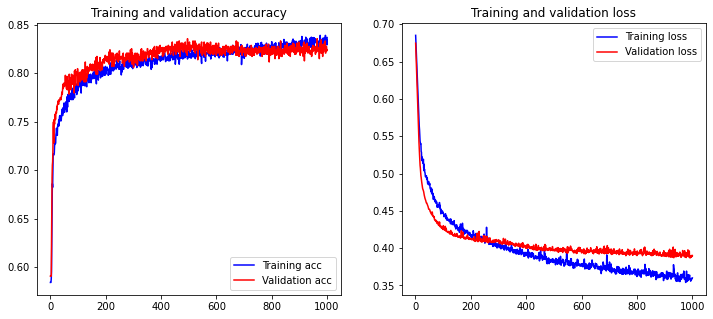

In [60]:
plot_history(history2)

In [61]:
# Sequential Model
y_pred_seq_model = seq_model.predict(X_val)
y_pred_seq = np.round(y_pred_seq_model).astype(int)

In [62]:
a,b,c,d = confusion_matrix(y_val, y_pred_seq).ravel()
print(a, b)
print(c, d)
print("correct:",str(a+d), "incorrect:",str(b+c))

440 77
77 281
correct: 721 incorrect: 154


## Submission

### Submission using Logistic Regression (logReg_model)

In [ ]:
submission_df["pred"] = logReg_model.predict(test_df)

In [ ]:
submission_df["pred"].describe()

In [ ]:
submission_df.to_csv("output/submission_lr_2.csv", header = False, index=False)

### Submission using Naives Bayes Classifier (naiveBayes_model)

In [ ]:
submission_df["pred"] = naiveBayes_model.predict(test_df)

In [ ]:
submission_df.to_csv("output/submission_naive.csv", header = False, index=False)

### Submission using ExtraTrees (et_clf)

In [ ]:
test_df_best = test_df[["Age", "Gender", "T_Bil", "ALP" ,"ALT_GPT" ,"TP", "Alb", "AG_ratio" ,"B_Bil" ,"AST_ALT_ratio"]]

In [ ]:
submission_df["pred"] = et_clf.predict(test_df_best)

In [ ]:
submission_df.to_csv("output/NEW_best_extra_trees.csv", header = False, index=False)

### Submission using Random Forest (rf_model)

In [ ]:
submission_df["pred"] = rf_model.predict(test_df)

In [ ]:
submission_df.to_csv("output/submission_random.csv", header = False, index=False)

### Sequential Model

In [64]:
y_pred_seq_model = seq_model.predict(test_df)
# y_pred_seq = np.round(y_pred_seq_model).astype(int)
submission_df["pred"] = y_pred_seq_model

In [65]:
submission_df.to_csv("output/Seq_0-1.csv", header = False, index=False)

## LightGLB

In [188]:
y_pred_light = gbm.predict(test_df)
# y_pred_light_model = np.round(y_pred_light).astype(int)
submission_df["pred"] = y_pred_light

In [189]:
submission_df.to_csv("output/l2.csv", header = False, index=False)